In [1]:
import sys
sys.path.append("/home/ubuntu/intelliscope/modules") # go to parent dir
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda,BatchNormalization
from tensorflow.keras import backend as K
from tensorflow_addons.layers import InstanceNormalization
import tensorflow_addons as tfa
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


from intelliscope import instead_data_loaders
from sklearn.metrics import classification_report
import numpy as np
from neptunecontrib.monitoring.metrics import *
plt.style.use('seaborn')

In [2]:
from tensorflow.keras.models import load_model


basepath = '/home/ubuntu/intelliscope/models/'


#Experiment(HYBIM-7).h5
project       = 'HYBIM'
model_number  = '7'
path = basepath + 'Experiment(' + project + '-' + model_number + ').h5'

In [3]:
print(path)

/home/ubuntu/intelliscope/models/Experiment(HYBIM-7).h5


In [4]:
PARAMS = {
    'notebook_name':'hybrid01_imbalanced_pcg_path', 
    'name':'data_a + BALANCED => [P22]', #(P7E1) 
    'description':'PCG model retrained on Data-a', #[PCG7,ECG1]
    'tags':[ 'CASS','p2.xlarge','transfer'],#,'RAdam'], 

    'data_balanced':False,    
    
    'pretrained': True, #
    'modelload_pcg_dir':'/home/ubuntu/intelliscope/models/Experiment(PCG-22).h5', # 22 is a good one
    'modelload_ecg_dir':'/home/ubuntu/intelliscope/models/Experiment(ECG-4).h5', #
    'ecg_trainable':True,
    'pcg_trainable':True,
    
    'is_features_normalized':False, 
    'Dilation_Rate':1,
    
    ##########################
    
    'augmentation':0,
    #'opt':tfa.optimizers.RectifiedAdam(lr=1e-3),
    'opt':tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    'dropout':0.2,    
    'num_epochs': 10,
    
    
    'wavelet':'comb1',    
    'batch_size':20,  
    'validation_split':0.1,
    'test_split': 0.2,
    'dataset':'physionet2016a',
    'pcg/ecg': 'pcg+ecg',
    'pcg_dir':'/home/ubuntu/intelliscope/for_dataloaders/waveletcomb1/dataA/pcg/',  
    'ecg_dir':'/home/ubuntu/intelliscope/for_dataloaders/waveletcomb1/dataA/ecg/', 
    'modelsave_dir':'/home/ubuntu/intelliscope/models',
    }

if PARAMS['data_balanced']==True:
    PARAMS['pcg_dir']+='balanced'
    PARAMS['ecg_dir']+='balanced'
else:
    PARAMS['pcg_dir']+='imbalanced'        
    PARAMS['ecg_dir']+='imbalanced'        
    

In [5]:
model = load_model(path)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 272, 462, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 272, 462, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 84)           329540      input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 3840)         47360       input_2[0][0]                    
____________________________________________________________________________________________

In [6]:
PARAMS['ecg_dir']

'/home/ubuntu/intelliscope/for_dataloaders/waveletcomb1/dataA/ecg/imbalanced'

In [7]:
X_test,Y_test = instead_data_loaders(PARAMS,'test')

X_test_pcg = X_test[:,:,:,0:3]/255.0
X_test_ecg = X_test[:,:,:,3:6]/255.0



Total  707
199 Images loaded across 2 Categories. Ignored blanks  60
508 Images loaded across 2 Categories. Ignored blanks  9
638 Total After removing blanks


In [8]:
y_pred = model.predict([X_test_pcg,X_test_ecg], batch_size=X_test.shape[0], verbose=1)

y_pred_bool = np.argmax(y_pred, axis=1)
y_test=np.argmax(Y_test,axis=1)

z = classification_report(y_test, y_pred_bool)
print(z)

638/638 [==============================] - 3s 5ms/sample
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       139
           1       0.89      0.94      0.92       499

    accuracy                           0.87       638
   macro avg       0.82      0.76      0.78       638
weighted avg       0.86      0.87      0.86       638



In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
threshold = 0.666667

print(confusion_matrix(y_test, y_pred[:, 1] > threshold))
print(f1_score(y_test, y_pred[:, 1] > threshold))
#roc_auc_score(y_test, y_pred) 

[[ 88  51]
 [ 33 466]]
0.9173228346456693


In [10]:
import custom_metrics

In [11]:
custom_metrics._class_metrics(y_test, y_pred[:, 1] > 0.666667)

{'accuracy': 0.8683385579937304,
 'precision': 0.9013539651837524,
 'recall': 0.9338677354709419,
 'f1_score': 0.9173228346456693,
 'f2_score': 0.9271786709112616,
 'matthews_corrcoef': 0.5969983099087193,
 'cohen_kappa': 0.594742971219431,
 'true_positive_rate': 0.9338677354709419,
 'true_negative_rate': 0.6330935251798561,
 'positive_predictive_value': 0.9013539651837524,
 'negative_predictive_value': 0.7272727272727273,
 'false_positive_rate': 0.3669064748201439,
 'false_negative_rate': 0.06613226452905811,
 'false_discovery_rate': 0.09864603481624758}

In [12]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])

roc_auc = roc_auc_score(y_test, y_pred[:, 1])

In [13]:
roc_auc

0.8893326220786897

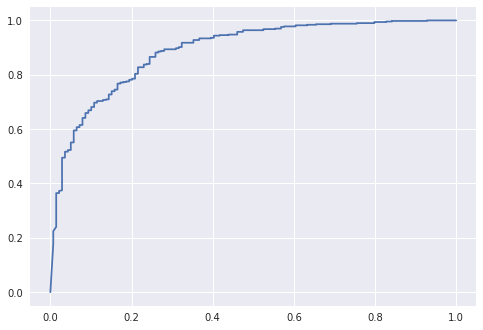

In [14]:
plt.plot(fpr,tpr)